In [1]:
import numpy as np
import scipy as sc
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import SimpSOM as sps
import minisom as msom
#import sompy
from umap import UMAP
from sklearn.manifold import TSNE

import random

import os
import sys
from collections import Counter
from collections import namedtuple
from collections import defaultdict
import inspect

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor, RANSACRegressor, BayesianRidge
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA, NMF
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer

from sklearn.cluster import SpectralClustering, AffinityPropagation, OPTICS, AgglomerativeClustering
from hdbscan import HDBSCAN


Data transformation:
* standard scaling
* robust scaler 

Feature reduction:
* minimum univariate distribution difference
* PCA 
* UMAP

Clustering method:
* HDBSCAN
* Spectral
* SOM

This analysis should provide us with an intuition of the separability of the targets 
with the given features.

**Output**: clusters can be used as features. 

In [2]:
os.chdir("T:\laupodteam\AIOS\Bram")
HS = pd.read_csv("data/HeartScore/Data/MATRIX_FULL_23jul2019_ECG.csv", sep=";")
HS.drop('Door', axis=1, inplace=True)

index_cols = ['pathos_key', 'upod_id'] 
date_cols = ['AcquisitionDateTime_ECG'] 
meta_cols = ['setsrc', 'Analyzer']
pheno_cols = ['AGE', 'gender', 'BMI', 'RF_Diab', 'RF_Smok', 'RF_HyperTens', 'RF_HyperChol', 'RF_CVDHist', 'RF_FamHist', 'RF_obese30']
hs_cols = ['HS_AGE', 'HS_History', 'HS_ECG', 'HS_new', 'HS_RiskFacts', 'HS_new2']
tn_cols = ['tn_admission', 'tn_slope2', 'HN_TN']

# convert bool in int64
for _col in HS.columns.tolist():
    if str(HS[_col].dtype)=='bool':
        HS[_col] = HS[_col].astype(int)
        
target = 'casecontrol'
HS.rename(index=str, columns={target: 'target'}, inplace=True)
tmap = {'Control': 0, 'NSTEMI': 1}
HS['target'] = HS.target.map(tmap)

gmap = {'M': 0, 'F': 1}
HS['gender'] = HS.gender.map(gmap)

HS.set_index(index_cols, inplace=True)

cols = HS.columns.tolist()
var_cols = list(set(cols) - set(meta_cols) - set(index_cols) -set(date_cols) - set(['target']))

cell_dyn_cols = ["c_b_wbc","c_b_wvf","c_b_neu","c_b_seg","c_b_bnd","c_b_ig","c_b_lym","c_b_lyme","c_b_vlym","c_b_mon","c_b_mone","c_b_blst",
                 "c_b_eos","c_b_bas","c_b_pneu","c_b_pseg","c_b_pbnd","c_b_pig","c_b_plym","c_b_plyme","c_b_pvlym","c_b_pmon","c_b_pmone",
                 "c_b_pblst","c_b_peos","c_b_pbas","c_b_namn","c_b_nacv","c_b_nimn","c_b_nicv","c_b_npmn","c_b_npcv","c_b_ndmn",
                 "c_b_ndcv","c_b_nfmn","c_b_nfcv","c_b_Lamn","c_b_Lacv","c_b_Limn","c_b_Licv","delay_Celldyn"]
ecg_cols_agg =  ["VentricularRate_ECG","AtrialRate_ECG","P_RInterval_ECG","QRS_Duration_ECG","Q_TInterval_ECG",
                 "QTCCalculation_ECG","PAxis_ECG","RAxis_ECG","TAxis_ECG","QRSCount_ECG","QOnset_ECG",
                 "QOffset_ECG","POnset_ECG","POffset_ECG","T_Onset_ECG","T_Offset_ECG","QRS_Onset_ECG",
                 "QRS_Offset_ECG","AvgRRInterval_ECG","QTcFredericia_ECG","QTcFramingham_ECG","QTc_Bazett_ECG"]

ecg_leads = ['Lead_I_', 'Lead_II_', 'Lead_III_', 'Lead_V1_', 'Lead_V2_', 'Lead_V3_', 'Lead_V4_', 'Lead_V5_', 'Lead_V6_', 'Lead_aVF_', 'Lead_aVL_', 'Lead_aVR_']
ecg_msrmnt = ['MaxST_ECG',  'Max_R_Ampl_ECG', 'Max_S_Ampl_ECG', 'MinST_ECG', 'PFull_Area_ECG', 'PP_Area_ECG', 'PP_Duration_ECG',
 'PP_PeakAmpl_ECG', 'PP_PeakTime_ECG', 'P_Area_ECG', 'P_Duration_ECG', 'P_PeakAmpl_ECG', 'P_PeakTime_ECG', 'QRS_Area_ECG', 'QRS_Balance_ECG',
 'QRS_Deflection_ECG', 'QRSint_ECG', 'Q_Area_ECG', 'Q_Duration_ECG', 'Q_PeakAmpl_ECG', 'Q_PeakTime_ECG', 'RP_Area_ECG', 'RP_Duration_ECG', 'RP_PeakAmpl_ECG',
 'RP_PeakTime_ECG', 'R_Area_ECG', 'R_Duration_ECG', 'R_PeakAmpl_ECG', 'R_PeakTime_ECG', 'SP_Area_ECG', 'SP_Duration_ECG', 'SP_PeakAmpl_ECG', 
 'SP_PeakTime_ECG', 'STE_ECG', 'STJ_ECG', 'STM_ECG', 'S_Area_ECG', 'S_Duration_ECG', 'S_PeakAmpl_ECG', 'S_PeakTime_ECG',
 'TFull_Area_ECG', 'TP_Area_ECG', 'TP_Duration_ECG', 'TP_PeakAmpl_ECG', 'TP_PeakTime_ECG', 'T_Area_ECG', 'T_Duration_ECG', 'T_End_ECG',
 'T_PeakAmpl_ECG', 'T_PeakTime_ECG', 'T_Special_ECG', 'P_OnsetAmpl_ECG']


ecg_cols_dyn = [_lead+_msrmnt for _lead in ecg_leads for _msrmnt in ecg_msrmnt]

ecg_cols_agg = list(set(ecg_cols_agg) & set(var_cols))
ecg_cols_dyn = list(set(ecg_cols_dyn) & set(var_cols))
cell_dyn_cols = list(set(cell_dyn_cols) & set(var_cols))

ecg_cols = list(set(ecg_cols_agg+ecg_cols_dyn))
other_cols = list(set(var_cols)-set(ecg_cols)-set(cell_dyn_cols))

col_dict = {'ecg': ecg_cols, 'celldyn': cell_dyn_cols, 'other': other_cols}
print("ECG: {} cols, \t CELLDYN: {} cols".format(len(ecg_cols), len(cell_dyn_cols)))

ECG: 646 cols, 	 CELLDYN: 41 cols


In [3]:
scaler= {'ecg': StandardScaler(), 'celldyn': StandardScaler(), 'other': StandardScaler()} # StandardScaler(), MinMaxScaler(), RobustScaler() or None
dim_reduction = None # {'ecg': PCA(n_components=6), 'celldyn': PCA(n_components=20)} # dict with dimension reduction per data group, or one dim red for all, or None, methods: PCA, NMF, UMAP
# dict with column name and impute type: median, mean, remove, regressor, (nmf?), or None, or knnimputer, or iterative which uses a round-robin approach using BayesianRidge as the regressor

feature_weights = 'glm' # glm, tree, gam
clustering = 'hdbscan' # hdbscan, SOM, spectral
remove_nan_patients = False
imputance = {'BMI': MLPRegressor(hidden_layer_sizes=(70,70,30)), 
             'P_RInterval_ECG': RANSACRegressor(), 
             'POnset_ECG': RANSACRegressor(), 
             'PAxis_ECG': RANSACRegressor(), 
             'POffset_ECG': RANSACRegressor(),
             'delay_Celldyn': BayesianRidge()}

## Imputance

In [4]:
print("Num NaN columns : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=0)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=0)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=0)>0).sum()))
###
print("Num NaN samples : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=1)>0).sum()))

Num NaN columns : ECG 4	CELLDYN 1	OTHER 1
Num NaN samples : ECG 75	CELLDYN 82	OTHER 64


In [5]:
if remove_nan_patients:
    nan_patients = HS[var_cols].isna().sum(axis=1)[HS[var_cols].isna().sum(axis=1)>0].index
    HS.drop(index=nan_patients, inplace=True)
    print("Num NaN samples : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[cell_dyn_cols].isna().sum(axis=1)>0).sum(),
                                                       (HS[other_cols].isna().sum(axis=1)>0).sum()))
    
    print("Num NaN columns : ECG {}\tCELLDYN {}\tOTHER {}".format((HS[ecg_cols].isna().sum(axis=0)>0).sum(),
                                                           (HS[cell_dyn_cols].isna().sum(axis=0)>0).sum(),
                                                           (HS[other_cols].isna().sum(axis=0)>0).sum()))   

y = HS[['target']]

In [6]:
# imputance

# consider adding Gaussian noise on top of the prediction
# https://www.kaggle.com/shashankasubrahmanya/missing-data-imputation-using-regression

if HS[var_cols].isna().sum().sum()>0:
    nan_cols = list(HS[var_cols].isna().sum()[HS[var_cols].isna().sum()>0].index)
    dat = HS.copy()
    if imputance is not None:
        if isinstance(imputance, dict):
            for _imp_key, _imp_val in imputance.items():
                if type(_imp_val)==str:
                    if _imp_val == 'median': 
                        dat.loc[dat[_imp_key].isna(), _imp_key] = np.nanmedian(dat[_imp_key])
                    elif _imp_val == 'mean':
                        dat.loc[dat[_imp_key].isna(), _imp_key] = np.nanmean(dat[_imp_key])
                    elif _imp_val == 'remove':
                        dat = dat.dropna(subset=[_imp_key])
                elif 'sklearn' in str(type(_imp_val)):  
                    _sub_cols = list(set(var_cols)  - set(nan_cols))
                    _y = dat.loc[~dat[_imp_key].isna(), _imp_key]
                    _X_train = dat.loc[~dat[_imp_key].isna(), _sub_cols]
                    _X_test = dat.loc[dat[_imp_key].isna(), _sub_cols]
                    try:
                        dat.loc[dat[_imp_key].isna(), _imp_key] = _imp_val.fit(_X_train, _y).predict(_X_test)
                    except Exception as e:
                        print("Imputance failed for {}, shapes: {}, {}, {}".format(_imp_key, _X_train.shape, _y.shape, _X_test.shape))
                        if _X_test.shape[0]==0:
                            print("Hmm, you probably already ran the imputer, please reload the data...")
        else:
            if imputance=='iterative':
                imp = IterativeImputer(estimator=BayesianRidge(), max_iter=10)
            elif imputance=='knnimputer':
                imp= KNNImputer(n_neighbors=5)

            dat = pd.DataFrame(data=imp.fit_transform(dat[var_cols]), index=HS.index, columns=var_cols)
            dat = dat.join(dat[meta_cols])
else:
    dat = HS

## Multi-collinearity

I.e. **the problem of removing all correlated pairs as efficiently as possible, meaning by removing a minimum number of nodes at the lowest computational cost.**

The efficient removal of multicollinearity can be cast in graph optimisation problem.

In [8]:
def _condition_number(x, ignore_nan=True):
    return np.linalg.cond(x.dropna(), p=2)

print("PRE: Condition numbers:\n\t\t ECG {}, \t CELLDYN {}, \t Other {}".format(_condition_number(dat[ecg_cols]), 
                                                                        _condition_number(dat[cell_dyn_cols]),
                                                                        _condition_number(dat[other_cols])))

PRE: Condition numbers:
		 ECG 2.7680569656610493e+18, 	 CELLDYN 146280465563.82697, 	 Other 1.725062701154116e+18


In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from statsmodels.tools.tools import add_constant

   
def coll_cols(x, threshold=0.99, how='corr_aff', ignore_nan=True):
    '''
     x : df
     threshold : maximum correlation or maximum VIF
     how : correlation (corr_aff, corr_pair) of VIF-based (vif)
    '''
    if ignore_nan:
        x=x.dropna() # x.fillna(x.median())   
    if how=='vif':
        cols = x.columns.tolist()
        cols_to_remove = []
        x = add_constant(x)
        x[cols] = StandardScaler().fit_transform(x[cols]) 
        vifs = []
        for idx, col in tqdm(enumerate(cols)):
            _vif = vif(x.values, idx)
            if _vif != np.inf:                
                vifs.append(_vif)
            if vif(x.values, idx)>threshold:
                cols_to_remove.append(col)
        vifs = np.array(vifs)
        print("VIF:\t max {}, \t min {}, \t mean {}, \t median {}".format(vifs.max(), vifs.min(), vifs.mean(), np.median(vifs)))
        plt.hist(np.log10(vifs), bins=50, density=True)
    elif how=='corr_aff':
        corrcoefs = x.corr().values  # np.corrcoef(tmp[var_cols]) , tmp[var_cols].corr().values         

        AF = AffinityPropagation(damping=0.65, max_iter=200, convergence_iter=50, preference=None, affinity='precomputed')
        labels = AF.fit_predict(-1/corrcoefs**2)
        exemplars = AF.cluster_centers_indices_
        cols_to_remove = [var_cols[i] for i in exemplars]
    elif how=='corr_pair':
        # simplistic 
        corrcoefs = x.corr().values # np.abs(np.corrcoef(x, rowvar=False))
        conn_count = { k: 0 for k in var_cols}
        conn_nodes = defaultdict(list)
        for idx, _colx in enumerate(var_cols):
            for jdx, _coly in enumerate(var_cols):
                if jdx<idx:
                    if corrcoefs[idx, jdx]>threshold:
                        conn_count[_colx]  += 1
                        conn_count[_coly]  += 1
                        conn_nodes[_colx]  += [_coly]
                        conn_nodes[_coly]  += [_colx]         
        cols_to_remove = [_v[0] for _v in conn_nodes.values()]
        
    print("{} columns should be removed due to collinearity.".format(len(cols_to_remove)))  
    return cols_to_remove



c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
14it [00:15,  1.08s/it]c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
706it [12:26,  1.06s/it]


VIF:	 max 115476913522320.4, 	 min 0.9999999999999998, 	 mean 869820003090.6094, 	 median 232.17853514431766
117 columns should be removed due to collinearity.
POST: Condition numbers:
		 ECG 2.5325043784176255e+19, 	 CELLDYN 14852771589.081522, 	 Other 38648.6984879425


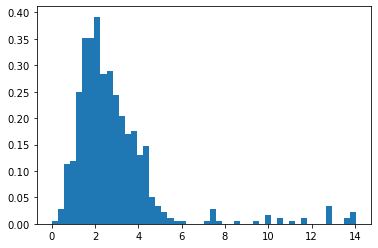

In [10]:
drop_cols = coll_cols(dat[var_cols], how='vif', threshold=5000000, ignore_nan=False)
#tmp.drop(drop_cols, axis=1, inplace=True)
ecg_cols = list(set(ecg_cols).difference(set(drop_cols)))
cell_dyn_cols = list(set(cell_dyn_cols).difference(set(drop_cols)))
other_cols = list(set(other_cols).difference(set(drop_cols)))
var_cols = list(set(var_cols).difference(set(drop_cols)))
print("POST: Condition numbers:\n\t\t ECG {}, \t CELLDYN {}, \t Other {}".format(_condition_number(dat[ecg_cols]), 
                                                                        _condition_number(dat[cell_dyn_cols]),
                                                                        _condition_number(dat[other_cols])))


# Dimension reduction

### Relative variance

In [11]:
def remove_min_variance(x, threshold=0.05):
    cols_to_keep = (x.var()/(x.max()-x.min()))\
        [((x.var()/(x.max()-x.min()))>threshold)].index   
    drop_cols = list(set(x.columns)-set(cols_to_keep))
    return x[cols_to_keep], drop_cols

tmp_keep, drop_cols = remove_min_variance(dat[var_cols], threshold=0.05)
print("Removing {} columns due to lack of variance".format(dat[var_cols].shape[1] - tmp_keep.shape[1]))

ecg_cols = set(ecg_cols).difference(set(drop_cols))
cell_dyn_cols = set(cell_dyn_cols).difference(set(drop_cols))
other_cols = set(other_cols).difference(set(drop_cols))
var_cols = set(var_cols).difference(set(drop_cols))


(tmp_keep.std()/(tmp_keep.max() - tmp_keep.min())).plot.hist(bins=50)
plt.title('Relative STD')

col_dict = {'ecg': list(ecg_cols), 'celldyn': list(cell_dyn_cols), 'other': list(other_cols)}

print("POST: Condition numbers:\n\t\t ECG {}, \t CELLDYN {}, \t Other {}".format(_condition_number(dat[ecg_cols]), 
                                                                        _condition_number(dat[cell_dyn_cols]),
                                                                        _condition_number(dat[other_cols])))

## feature selection
* ANOVA
* FDR
* KS
* Wasserstein

In [ ]:
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif, SelectFdr


## embedding
* PCA
* UMAP
* NMF

In [15]:
# Dim reduction
if dim_reduction is not None:
    if isinstance(dim_reduction, dict):
        assert(set(dim_reduction.keys()).issubset(['ecg', 'celldyn'])), "Check the dim_reduction keys"
        ecols = ['ecg_'+str(i) for i in range(0, dim_reduction['ecg'].n_components)]
        ecg_red = pd.DataFrame(dim_reduction['ecg'].fit_transform(dat[ecg_cols]), index=dat.index, columns=ecols)
        ccols = ['celldyn_'+str(i) for i in range(0, dim_reduction['celldyn'].n_components)]
        celldyn_red = pd.DataFrame(dim_reduction['celldyn'].fit_transform(dat[cell_dyn_cols]), index=dat.index, columns=ccols)
        
        dat_red = dat[other_cols].join(ecg_red).join(celldyn_red)
    else:
        rcols = ['red_'+str(i) for i in range(0, dim_reduction['ecg'].n_components)]
        tot_red = pd.DataFrame(dim_reduction.fit_transform(dat[var_cols]), index=dat.index, columns=rcols)
        dat_red = dat[other_cols].join(tot_red)

## Scaling

In [15]:
# Scaling
if scaler is not None:
    if isinstance(scaler, dict):        
        for _imp_key, _scaler in scaler.items():
            if _scaler is not None:
                dat[col_dict[_imp_key]] = _scaler.fit_transform(dat[col_dict[_imp_key]]) 
    else:    
        dat[var_cols] = pd.DataFrame(data=scaler.fit_transform(dat[var_cols]), index=HS.index, columns=var_cols)


## Outliers

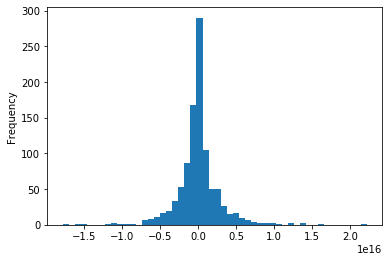

In [16]:
# Mahalanobis distance for outliers
def mahalanobis(x=None, cov=None):
    # source: https://www.machinelearningplus.com/statistics/mahalanobis-distance/
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(x)
    if not cov:
        cov = np.cov(x.values.T)
    inv_covmat = sc.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

mah = mahalanobis(dat[var_cols])
dat['_maha'] = mah
# isolation forest
dat._maha.plot.hist(bins=50)

out_idx_dict= {}

iso = IsolationForest(n_estimators=400, n_jobs=4)
out_in = iso.fit_predict(dat[var_cols])
out_idx_dict['iso'] = np.where(out_in==-1)
in_idx = np.where(out_in==1)

ocs = OneClassSVM(kernel='rbf', gamma='scale', max_iter=1000)
out_in = ocs.fit_predict(dat[var_cols])
out_idx_dict['svm'] = np.where(out_in==-1)

## Reduced dimensionality visualisation

### PCA

In [21]:
print("ECG: {} cols, \t CELLDYN: {} cols, \t OTHER:{} cols".format(len(ecg_cols), len(cell_dyn_cols), len(other_cols)))

ECG: 538 cols, 	 CELLDYN: 21 cols, 	 OTHER:16 cols


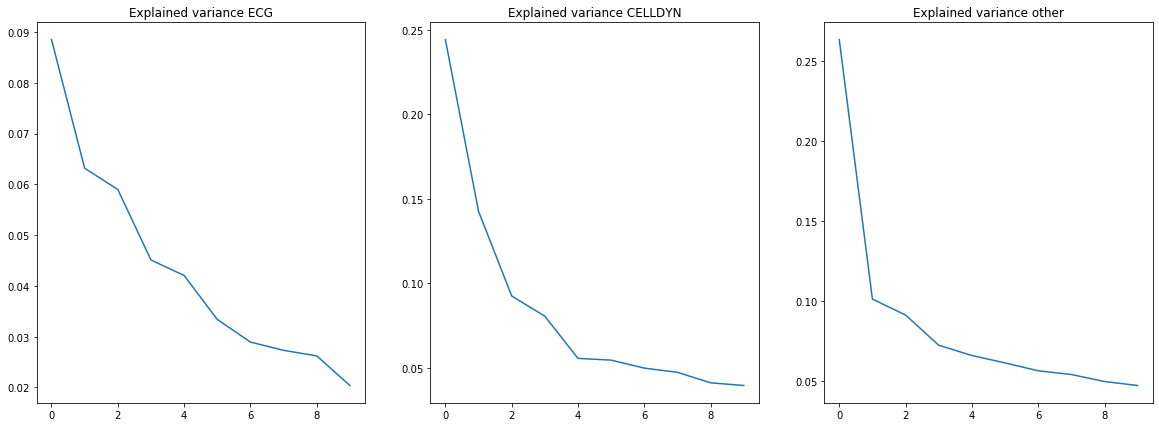

In [22]:
dat_viz={}
nc = 10
red_cols = ['pc_'+str(i) for i in range(0, nc)]
pc = {}
fig, ax = plt.subplots(ncols=3, figsize=(20,7))

pc['ecg'] = PCA(n_components=nc, svd_solver='full')
tred = pc['ecg'].fit_transform(dat[ecg_cols])
ax[0].plot(pc['ecg'].explained_variance_ratio_)
ax[0].set_title('Explained variance ECG')
dat_viz['pca_celldyn']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

pc['celldyn'] = PCA(n_components=nc, svd_solver='full')
tred = pc['celldyn'].fit_transform(dat[cell_dyn_cols])
ax[1].plot(pc['celldyn'].explained_variance_ratio_)
ax[1].set_title('Explained variance CELLDYN')
dat_viz['pca_ecg']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

pc['other'] = PCA(n_components=nc, svd_solver='full')
tred = pc['other'].fit_transform(dat[other_cols])
ax[2].plot(pc['other'].explained_variance_ratio_)
ax[2].set_title('Explained variance other')
dat_viz['pca_other'] = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

The explained variance of the first component is huge, this suggests that there is a leaking feature.

Text(0.5, 1.0, 'other PC 2')

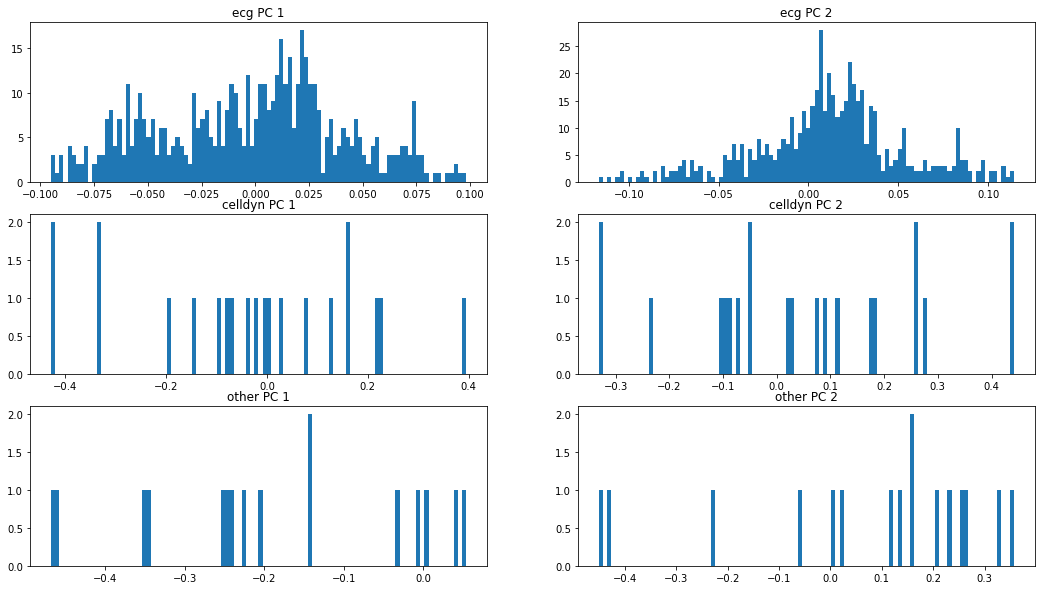

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(18,10))
ax[0,0].hist(pc['ecg'].components_[0], bins=100); ax[0,0].set_title('ecg PC 1')
ax[0,1].hist(pc['ecg'].components_[1], bins=100); ax[0,1].set_title('ecg PC 2')
ax[1,0].hist(pc['celldyn'].components_[0], bins=100); ax[1,0].set_title('celldyn PC 1')
ax[1,1].hist(pc['celldyn'].components_[1], bins=100); ax[1,1].set_title('celldyn PC 2')
ax[2,0].hist(pc['other'].components_[0], bins=100); ax[2,0].set_title('other PC 1')
ax[2,1].hist(pc['other'].components_[1], bins=100); ax[2,1].set_title('other PC 2')

Text(0.5, 1.0, 'PCA OTHER')

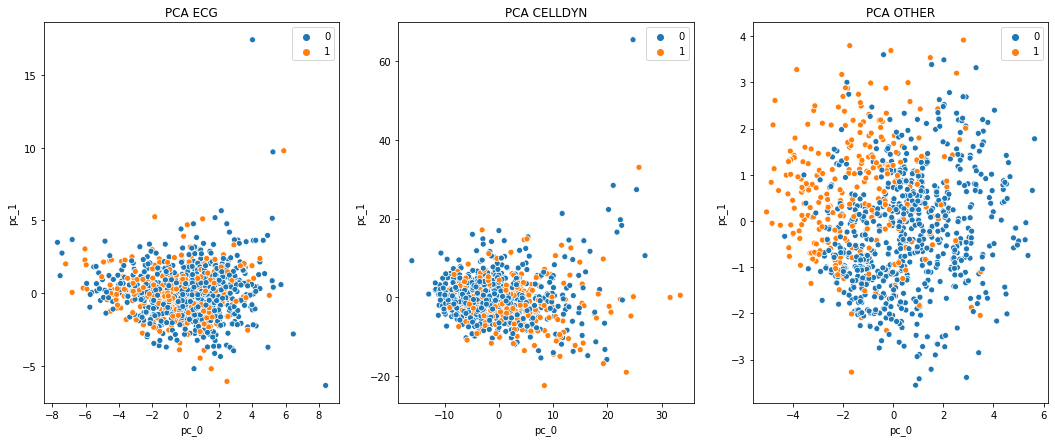

In [24]:
fig, ax = plt.subplots(ncols=3, figsize=(18,7))
sns.scatterplot(data=dat_viz['pca_ecg'], x='pc_0', y='pc_1', hue=y.values[:,0], ax=ax[0])
sns.scatterplot(data=dat_viz['pca_celldyn'], x='pc_0', y='pc_1', hue=y.values[:,0], ax=ax[1])
sns.scatterplot(data=dat_viz['pca_other'], x='pc_0', y='pc_1', hue=y.values[:,0], ax=ax[2])
ax[0].set_title('PCA ECG')
ax[1].set_title('PCA CELLDYN')
ax[2].set_title('PCA OTHER')

## NMF

In [53]:
nc = 20
red_cols = ['pc_'+str(i) for i in range(0, nc)]

nnmf = {}
nnmf['ecg'] = NMF(n_components=nc)
tred = nnmf['ecg'].fit_transform(dat[ecg_cols]+dat[ecg_cols].min().abs())
dat_viz['nmnf_ecg']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

nnmf['celldyn'] = NMF(n_components=nc)
tred = nnmf['celldyn'].fit_transform(dat[cell_dyn_cols]+dat[cell_dyn_cols].min().abs())
dat_viz['nmnf_celldyn']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

nnmf['other'] = NMF(n_components=nc)
tred = nnmf['other'].fit_transform(dat[other_cols]+dat[other_cols].min().abs())
dat_viz['nmnf_other']  = pd.DataFrame(data=tred, index=dat.index, columns=red_cols)

print("Reconstruction errors: ECG {}, \t CELLDYN {}, \t OTHER {}".format(nnmf['ecg'].reconstruction_err_, 
                                                                         nnmf['celldyn'].reconstruction_err_,
                                                                         nnmf['other'].reconstruction_err_))

Reconstruction errors: ECG 508.75632351244366, 	 CELLDYN 3.6137771269548726, 	 OTHER 4.972870472204828


Text(0.5, 1.0, 'NMF OTHER')

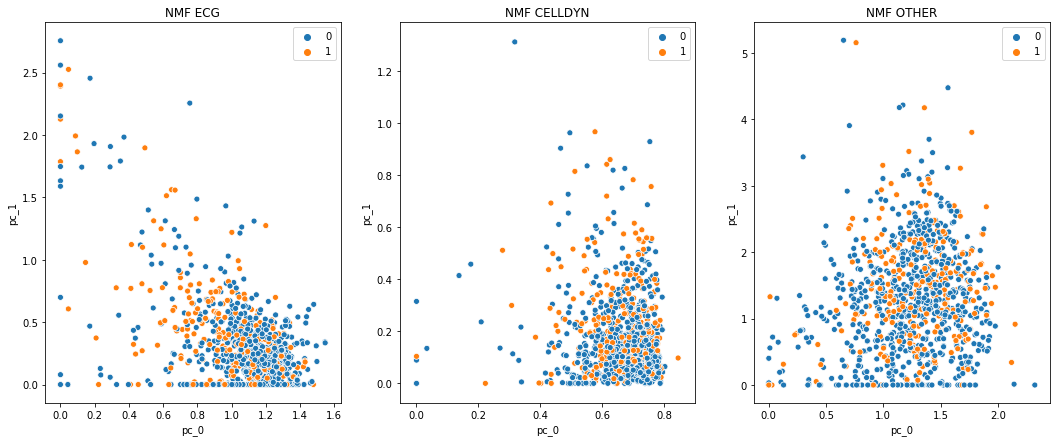

In [57]:
fig, ax = plt.subplots(ncols=3, figsize=(18,7))
sns.scatterplot(data=dat_viz['nmnf_ecg'], x='pc_0', y='pc_1', hue=y.values[:,0], ax=ax[0])
sns.scatterplot(data=dat_viz['nmnf_celldyn'], x='pc_0', y='pc_1', hue=y.values[:,0], ax=ax[1])
sns.scatterplot(data=dat_viz['nmnf_other'], x='pc_0', y='pc_1', hue=y.values[:,0], ax=ax[2])
ax[0].set_title('NMF ECG')
ax[1].set_title('NMF CELLDYN')
ax[2].set_title('NMF OTHER')

### UMAP

In [25]:
um_ecg = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
um_celldyn = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
um_other = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
um_all = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)

In [26]:
dat_viz['umap_other'] =  pd.DataFrame(data=um_other.fit_transform(dat[other_cols]), index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])
dat_viz['umap_ecg'] = pd.DataFrame(data=um_ecg.fit_transform(dat[ecg_cols]), index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])
dat_viz['umap_celldyn'] = pd.DataFrame(data=um_celldyn.fit_transform(dat[cell_dyn_cols]), index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])
dat_viz['umap_all'] = pd.DataFrame(data=um_all.fit_transform(dat[var_cols]), index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])

Text(0.5, 1.0, 'UMAP OTHER')

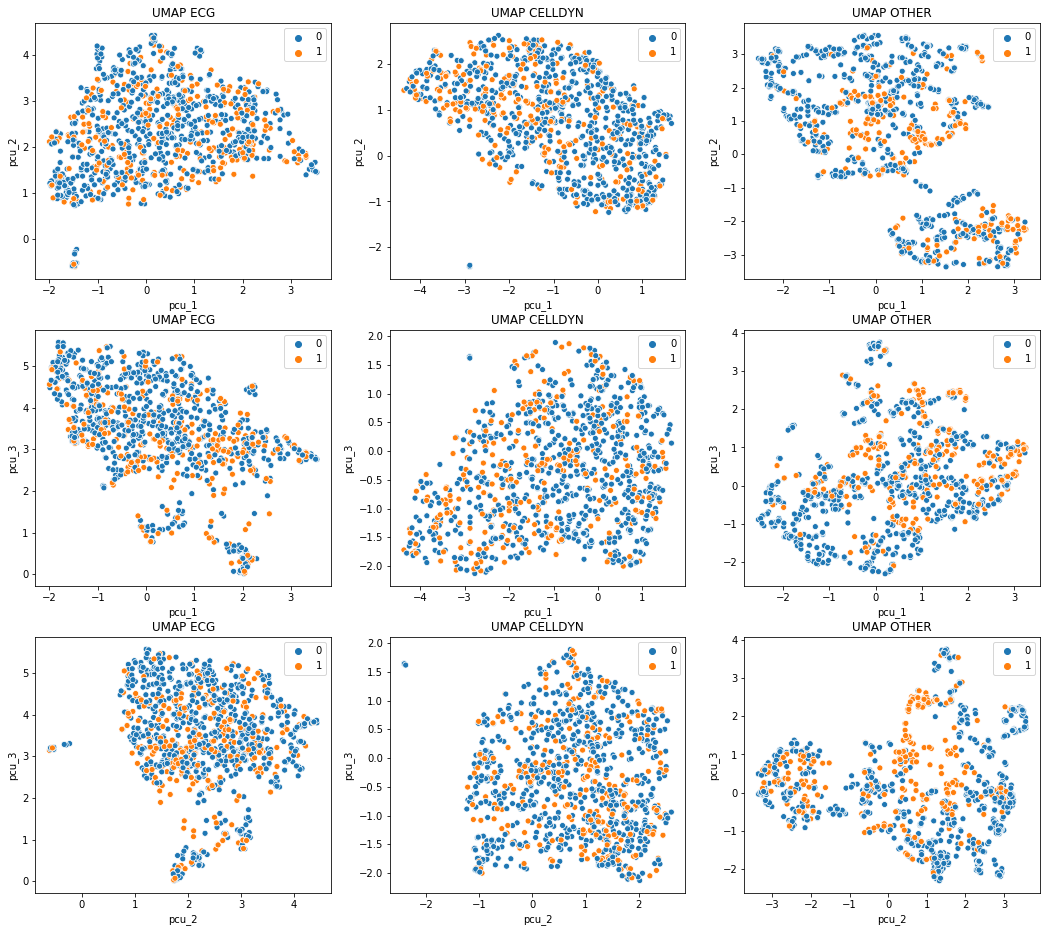

In [27]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(18,16))
sns.scatterplot(data=dat_viz['umap_ecg'], x='pcu_1', y='pcu_2', hue=y.values[:,0], ax=ax[0,0])
sns.scatterplot(data=dat_viz['umap_celldyn'], x='pcu_1', y='pcu_2', hue=y.values[:,0], ax=ax[0,1])
sns.scatterplot(data=dat_viz['umap_other'], x='pcu_1', y='pcu_2', hue=y.values[:,0], ax=ax[0,2])
ax[0,0].set_title('UMAP ECG')
ax[0,1].set_title('UMAP CELLDYN')
ax[0,2].set_title('UMAP OTHER')

sns.scatterplot(data=dat_viz['umap_ecg'], x='pcu_1', y='pcu_3', hue=y.values[:,0], ax=ax[1,0])
sns.scatterplot(data=dat_viz['umap_celldyn'], x='pcu_1', y='pcu_3', hue=y.values[:,0], ax=ax[1,1])
sns.scatterplot(data=dat_viz['umap_other'], x='pcu_1', y='pcu_3', hue=y.values[:,0], ax=ax[1,2])
ax[1,0].set_title('UMAP ECG')
ax[1,1].set_title('UMAP CELLDYN')
ax[1,2].set_title('UMAP OTHER')

sns.scatterplot(data=dat_viz['umap_ecg'], x='pcu_2', y='pcu_3', hue=y.values[:,0], ax=ax[2,0])
sns.scatterplot(data=dat_viz['umap_celldyn'], x='pcu_2', y='pcu_3', hue=y.values[:,0], ax=ax[2,1])
sns.scatterplot(data=dat_viz['umap_other'], x='pcu_2', y='pcu_3', hue=y.values[:,0], ax=ax[2,2])
ax[2,0].set_title('UMAP ECG')
ax[2,1].set_title('UMAP CELLDYN')
ax[2,2].set_title('UMAP OTHER')

Text(0.5, 0.98, 'UMAP ALL')

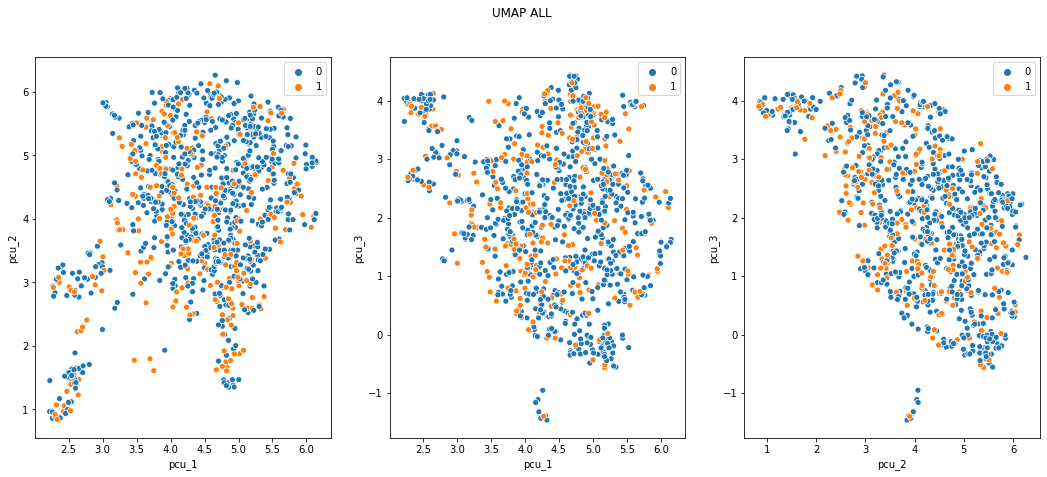

In [28]:
fig, ax = plt.subplots(ncols=3, figsize=(18,7))
sns.scatterplot(data=dat_viz['umap_all'], x='pcu_1', y='pcu_2', hue=y.values[:,0], ax=ax[0])
sns.scatterplot(data=dat_viz['umap_all'], x='pcu_1', y='pcu_3', hue=y.values[:,0], ax=ax[1])
sns.scatterplot(data=dat_viz['umap_all'], x='pcu_2', y='pcu_3', hue=y.values[:,0], ax=ax[2])
fig.suptitle('UMAP ALL')

In [58]:
# Supervised UMAP
um_all_sup = UMAP(n_components=3, n_neighbors=10, min_dist=0.1)
dat_viz['umap_all'] = pd.DataFrame(data=um_all.fit_transform(dat[var_cols], 
                                                             y=y.values.astype(np.int16)), 
                                   index=dat.index, columns=['pcu_1', 'pcu_2', 'pcu_3'])

LoweringError: Failed in nopython mode pipeline (step: nopython mode backend)
[1m[1mCannot cast array(bool, 1d, C) to bool: %".591" = load {i8*, i8*, i64, i64, i8*, [1 x i64], [1 x i64]}, {i8*, i8*, i64, i64, i8*, [1 x i64], [1 x i64]}* %"$18.12"
[1m
File "c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\umap\umap_.py", line 535:[0m
[1mdef fast_intersection(rows, cols, values, target, unknown_dist=1.0, far_dist=5.0):
    <source elided>
        j = cols[nz]
[1m        if (target[i] == -1) or (target[j] == -1):
[0m        [1m^[0m[0m
[0m
[0m[1m[1] During: lowering "branch $18.12, 60, 48" at c:\users\bes3\appdata\local\programs\python\python37\lib\site-packages\umap\umap_.py (535)[0m

-------------------------------------------------------------------------------
This should not have happened, a problem has occurred in Numba's internals.
You are currently using Numba version 0.46.0.

Please report the error message and traceback, along with a minimal reproducer
at: https://github.com/numba/numba/issues/new

If more help is needed please feel free to speak to the Numba core developers
directly at: https://gitter.im/numba/numba

Thanks in advance for your help in improving Numba!



## SOM clustering

Periodic Boundary Conditions active.
The weights will be initialised with PCA.
Training SOM... done!


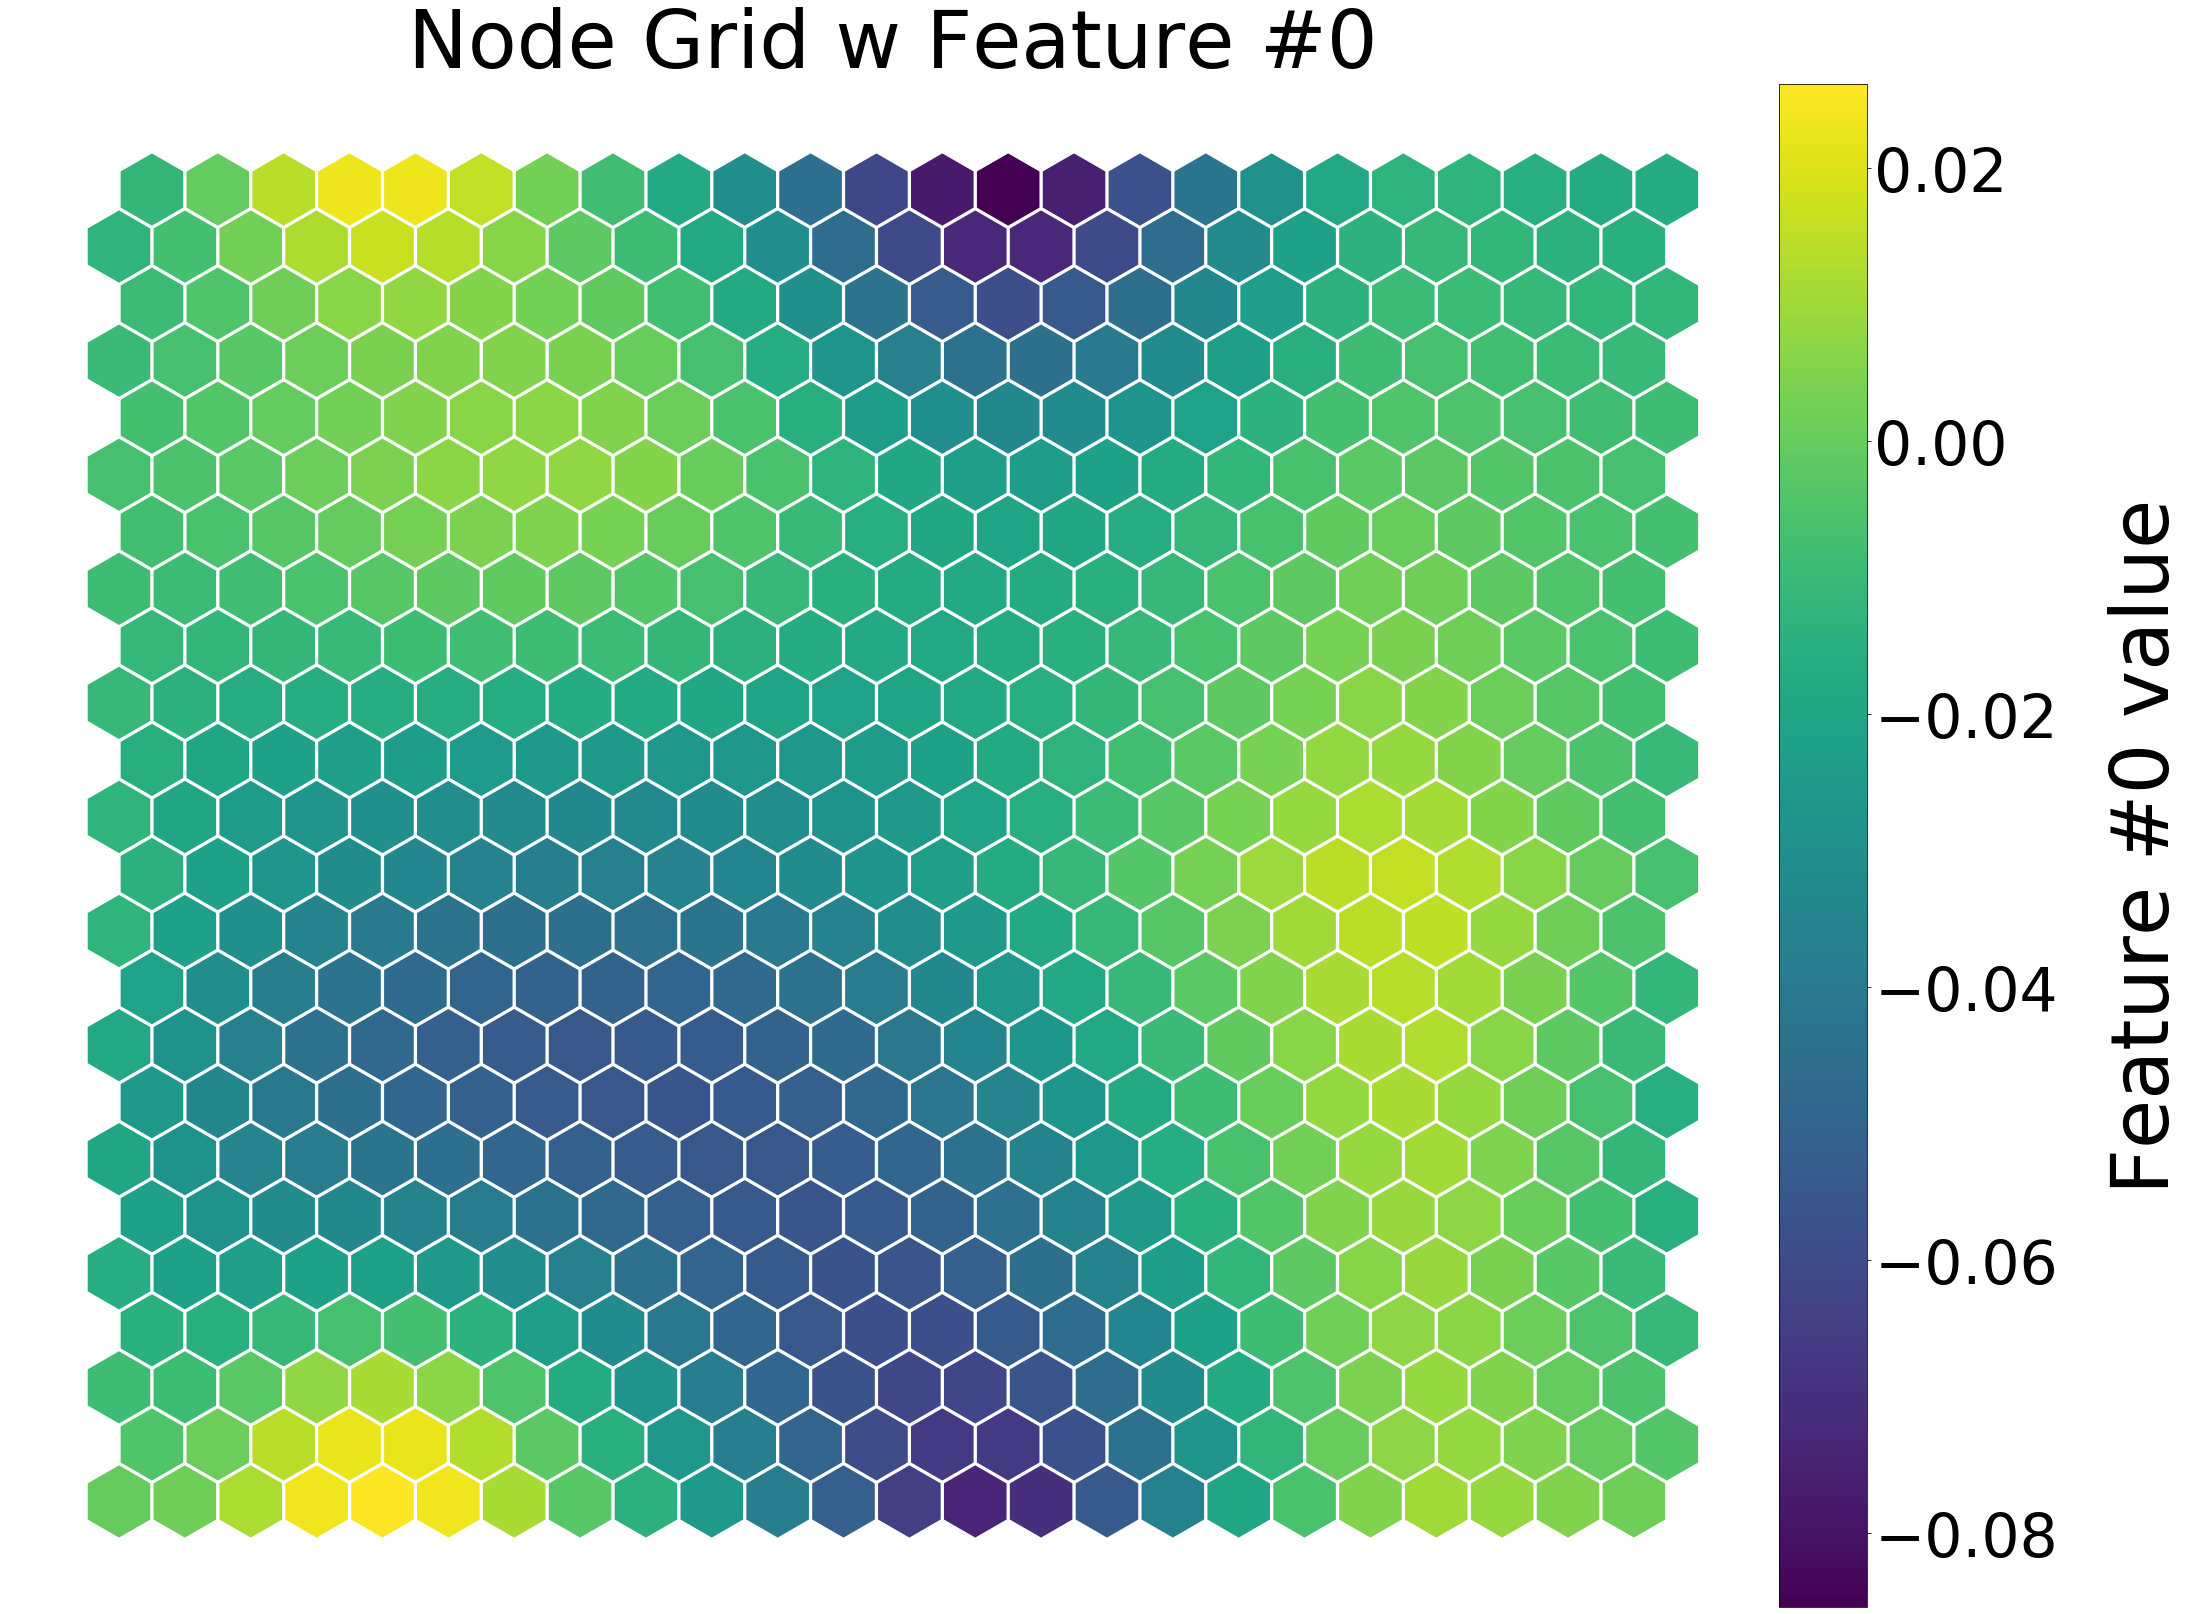

<Figure size 2400x2400 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [54]:
# Clustering
# Cluster both dat_red and dat
# SOM: https://github.com/fcomitani/SimpSOM
# miniSOM: https://github.com/JustGlowing/minisom
# SOMPY: https://gist.github.com/sevamoo/035c56e7428318dd3065013625f12a11
# customSOM : https://pythonhosted.org/kohonen/_modules/kohonen/kohonen.html
net = sps.somNet(24, 24, dat[var_cols].values, PBC=True, n_jobs=4, PCI=True)
net.train(0.01, 1000)
net.nodes_graph(colnum=0)
net.diff_graph()
plt.show()

In [55]:
#Project the datapoints on the new 2D network map.
net.project(dat[var_cols].values, labels=HS.target.values) #  labels=labels
#Cluster the datapoints according to the Quality Threshold algorithm.
plt.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
net.cluster(dat[var_cols].values, type='qthresh')

In [ ]:
# Spectral
# pre-set 2 clusters

# Agglomerative 
# pre-set 2 clusters

# OPTICS 


# HDBSCAN


In [240]:
# Separability of clusters by target





# One more try, using supervised clustering.